In [71]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [2]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [84]:
# Getting AAPL's historical data from yfinance
aapl_data = yf.download('AAPL',start = '2019-06-25', end = '2024-06-25')
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-25,49.607498,49.814999,48.822498,48.892502,47.186008,84281200
2019-06-26,49.442501,50.247501,49.337502,49.950001,48.206612,104270000
2019-06-27,50.072498,50.392502,49.892502,49.935001,48.192135,83598800
2019-06-28,49.669998,49.875000,49.262501,49.480000,47.753010,124442400
2019-07-01,50.792500,51.122501,50.162498,50.387501,48.628841,109012000


In [85]:
#Data cleaning
#filling in missing values
aapl_data.fillna(method='ffill',inplace=True)

In [86]:
# optionally we can check for anomalies by maybe selecting rows with
# exceptionally high values for features or large difference between High and
# Low etc...
aapl_data[aapl_data["High"] - aapl_data["Low"] > 100].head()
#sanity check done

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [87]:
#Feature Selection
# adjusted close price more reliable than close price as it is adjusted for any
# corporate actions like stock splits. Lets use adjusted close price analysis %%

In [88]:
#normalisation of feature (lets use min-max as values should be positive(Z-score ruled out))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Adj Close'].values.reshape(-1,1))
aapl_data_scaled

array([[0.00316449],
       [0.00916726],
       [0.00908211],
       ...,
       [0.95888765],
       [0.94600704],
       [0.95365303]])

In [89]:
#Sequence Length = 75 days for LSTM to predict
X = []
y = []
for i in range(75,len(aapl_data_scaled)):
  X.append(aapl_data_scaled[i-75:i,0])
  y.append(aapl_data_scaled[i,0])

#Train Test Split(70-30)
train_size = int(len(X)*0.7)

X_train, X_test = X[:train_size],X[train_size:]
y_train,y_test = y[:train_size],y[train_size:]

X_train,y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1));
#[samples,time steps, features] format needed for LSTM
X_train

array([[[0.00316449],
        [0.00916726],
        [0.00908211],
        ...,
        [0.04907551],
        [0.04528644],
        [0.04903273]],

       [[0.00916726],
        [0.00908211],
        [0.00649936],
        ...,
        [0.04528644],
        [0.04903273],
        [0.05339164]],

       [[0.00908211],
        [0.00649936],
        [0.01165064],
        ...,
        [0.04903273],
        [0.05339164],
        [0.06210936]],

       ...,

       [[0.55524614],
        [0.57650337],
        [0.57825045],
        ...,
        [0.51864612],
        [0.51438759],
        [0.5147376 ]],

       [[0.57650337],
        [0.57825045],
        [0.5726013 ],
        ...,
        [0.51438759],
        [0.5147376 ],
        [0.52990476]],

       [[0.57825045],
        [0.5726013 ],
        [0.54150182],
        ...,
        [0.5147376 ],
        [0.52990476],
        [0.54880543]]])

In [90]:
#LSTM layers creation and addition
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,AdditiveAttention,Permute,Reshape,Multiply

model = Sequential()

model.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences = True))


In [91]:
#Attention Integration
attention = AdditiveAttention(name='attention_weight')
#Permute & Reshape to make compatible
model.add(Permute((2,1)))
model.add(Reshape((-1,X_train.shape[1])))
attention_result = attention([model.output,model.output])
multiply_layer = Multiply()([model.output,attention_result])
#Return to original shape
model.add(Permute((2,1)))
model.add(Reshape((-1,75)))
model.add(tf.keras.layers.Flatten())

#Dense Layer!!
model.add(Dense(1))

#Optimise Model
# Reduce overfitting by Dropout (making some inputs zero randomly) and Batch
# Normalisation to stabilise the learning process
from keras.layers import BatchNormalization

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.build()
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 75, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 75, 50)            20200     
                                                                 
 permute_33 (Permute)        (None, 50, 75)            0         
                                                                 
 reshape_14 (Reshape)        (None, 50, 75)            0         
                                                                 
 permute_34 (Permute)        (None, 75, 50)            0         
                                                                 
 reshape_15 (Reshape)        (None, 50, 75)            0         
                                                                 
 flatten_5 (Flatten)         (None, 3750)             

In [92]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()
history = model.fit(X_train,y_train,epochs=100,batch_size=25,validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 75, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 75, 50)            20200     
                                                                 
 permute_33 (Permute)        (None, 50, 75)            0         
                                                                 
 reshape_14 (Reshape)        (None, 50, 75)            0         
                                                                 
 permute_34 (Permute)        (None, 75, 50)            0         
                                                                 
 reshape_15 (Reshape)        (None, 50, 75)            0         
                                                                 
 flatten_5 (Flatten)         (None, 3750)             

In [93]:
#avoid overfitting using early stopping if validation set performance degrades
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train,y_train,epochs=100,batch_size=25,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 2s 78ms/step - loss: 0.0122 - val_loss: 0.0027
Epoch 2/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0099 - val_loss: 0.0049
Epoch 3/100
27/27 [==============================] - 2s 68ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 4/100
27/27 [==============================] - 3s 113ms/step - loss: 0.0105 - val_loss: 0.0012
Epoch 5/100
27/27 [==============================] - 3s 110ms/step - loss: 0.0132 - val_loss: 0.0019
Epoch 6/100
27/27 [==============================] - 2s 80ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 7/100
27/27 [==============================] - 2s 66ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 8/100
27/27 [==============================] - 2s 66ms/step - loss: 0.0115 - val_loss: 0.0022
Epoch 9/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0119 - val_loss: 0.0037
Epoch 10/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0093 - val_loss: 0.00

In [94]:
#Other callback options
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

checkpoint = ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.00001)
tensorboard = TensorBoard(log_dir='logs')
csv_logger = CSVLogger('training.csv')

callbacks = [checkpoint,reduce_lr,tensorboard,csv_logger,early_stopping]

history = model.fit(X_train,y_train,epochs=100,batch_size=25,validation_split=0.2,callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 2s 81ms/step - loss: 0.0104 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/100
 1/27 [>.............................] - ETA: 2s - loss: 0.0058

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 3s 102ms/step - loss: 0.0095 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0089 - val_loss: 0.0045 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 2s 92ms/step - loss: 0.0109 - val_loss: 0.0600 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 2s 90ms/step - loss: 0.0120 - val_loss: 8.8732e-04 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 2s 68ms/step - loss: 0.0102 - val_loss: 0.0067 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 2s 87ms/step - loss: 0.0113 - val_loss: 8.3710e-04 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 3s 98ms/step - loss: 0.0114 - val_loss: 0.0120 - lr: 0.0010
Epoch 9/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0123 - val_loss: 0.0019 - lr: 0.0010
Epoch 10/100
27/27 [==============================] - 2s 73ms/step - loss: 0.0090 - val_loss: 0.004

In [95]:
#Model Testing

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

test_loss = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')

12/12 [==============================] - 0s 20ms/step - loss: 0.0067
Test loss: 0.00669713132083416


In [96]:
#Model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test,y_pred)
rmse = mean_squared_error(y_test,y_pred,squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')



12/12 [==============================] - 1s 19ms/step
MAE: 0.07635338884449022
RMSE: 0.0818360044067024


In [97]:
#Model Prediction

#fetching latest 75 days of data needed for predictions of future prices

data = aapl_data[-75:]
data_scaled = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))
latest_75_days = data_scaled[-75:]
latest_75_days = np.array(latest_75_days)
latest_75_days = np.reshape(latest_75_days, (1,75,1))

#making predictions for next 4 candles

predicted_stock_prices = []
curr_batch = latest_75_days  # Start with the initial batch
for i in range(4):
  predicted_price = model.predict(curr_batch)  # Predict on the current batch
  predicted_stock_prices.append(scaler.inverse_transform(predicted_price)[0,0])

  # Prepare the next batch:
  # 1. Remove the oldest day from the current batch
  curr_batch = curr_batch[:, 1:, :]
  # 2. Reshape the predicted price to match the batch format
  predicted_price_reshaped = np.reshape(predicted_price,(1,1,1))
  # 3. Append the predicted price as the newest day in the batch
  curr_batch = np.append(curr_batch, predicted_price_reshaped, axis=1)

print(f'Predicted stock price for next 4 candles: {predicted_stock_prices}')

1/1 [==============================] - 0s 53ms/step
Predicted stock price for next 4 candles: [206.96637, 205.50452, 204.14503, 202.86186]


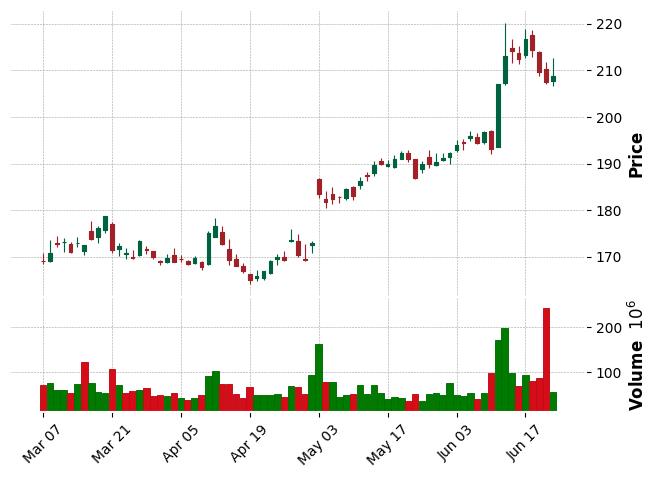

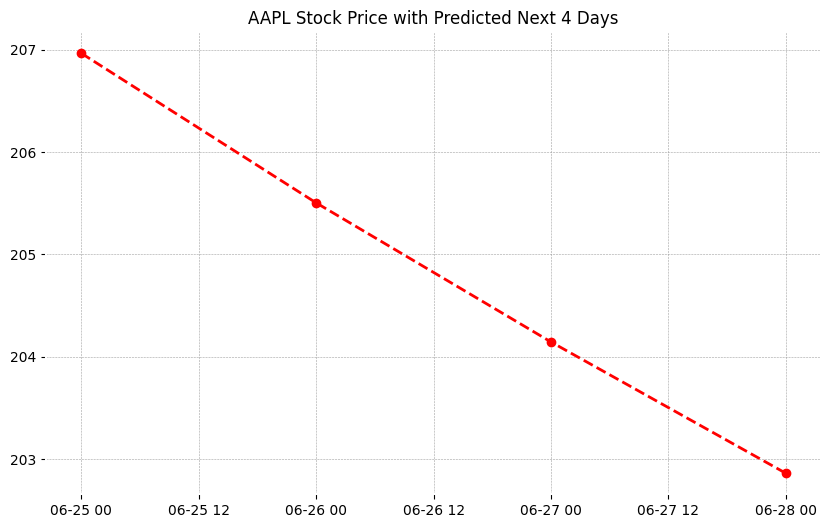

In [98]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_stock_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

1/1 [==============================] - 0s 48ms/step


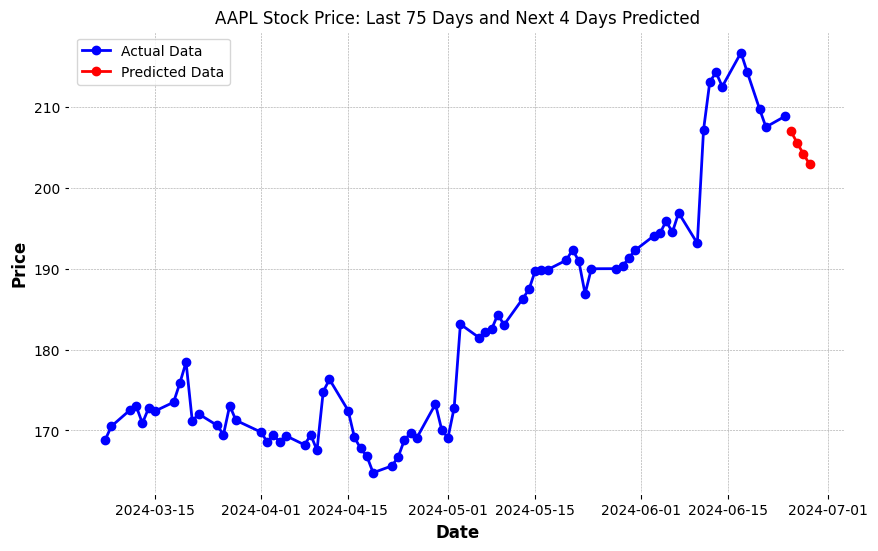

In [99]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 75 days of AAPL stock data
data = aapl_data[-79:] # Fetch 79 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-75:].reshape(1, 75, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Adj Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Adj Close'], predicted_data['Adj Close']])
combined_data = combined_data[-79:] # Last 75 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-75:], data['Adj Close'][-75:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 75 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()